# Tutorial 4: Integrating mouse embryo slices
This tutorial demonstrates STAligner's ablility to integrate four mouse embryo slices sampled at the time stages of E9.5, E10.5, E11.5 and E12.5 profiled by Stereo-seq. The raw data can be downloaded from https://db.cngb.org/stomics/mosta/.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/mnt/disk1/xzhou/anaconda3/envs/STAligner/lib/R"
os.environ['R_USER'] = "/mnt/disk1/xzhou/anaconda3/envs/STAligner/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
Batch_list = []
adj_list = []

section_ids = ['E9.5_E1S1', 'E10.5_E2S1', 'E11.5_E1S1', 'E12.5_E1S1']
for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad(os.path.join("Data/" + section_id + ".MOSTA.h5ad"))
    adata.X = adata.layers['count']

    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

    STAligner.Cal_Spatial_Net(adata, rad_cutoff=1.3)

    # Normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000) #ensure enough common HVGs in the combined matrix
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)


E9.5_E1S1
------Calculating spatial graph...
The graph contains 23166 edges, 5913 cells.
3.9178 neighbors per cell on average.
E10.5_E2S1
------Calculating spatial graph...
The graph contains 33410 edges, 8494 cells.
3.9334 neighbors per cell on average.
E11.5_E1S1
------Calculating spatial graph...
The graph contains 119204 edges, 30124 cells.
3.9571 neighbors per cell on average.
E12.5_E1S1
------Calculating spatial graph...
The graph contains 204168 edges, 51365 cells.
3.9748 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (95896, 693)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat) 

## Running STAligner

In [6]:
# Important parameter:
# "iter_comb" is used to specify the order of integration
# "margin" is used to control the intensity/weight of batch correction
iter_comb = [(0, 3), (1, 3), (2, 3)] ## Fix slice 3 as reference to align

adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 100, iter_comb = iter_comb,
                                                        margin=2.5,  device=used_device)

STAligner(
  (conv1): GATConv(693, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 693, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:34<00:00, 14.68it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|█▉        | 99/500 [00:39<00:27, 14.54it/s] 

Update spot triplets at epoch 600


 40%|███▉      | 199/500 [01:33<00:20, 14.38it/s]

Update spot triplets at epoch 700


 60%|█████▉    | 299/500 [02:35<00:13, 14.39it/s]

Update spot triplets at epoch 800


 80%|███████▉  | 399/500 [03:38<00:07, 14.40it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


## Clustering

In [7]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=0.4)

## Visualization

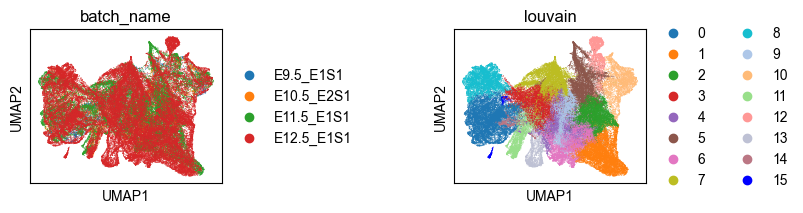

In [8]:
sc.tl.umap(adata_concat, random_state=666)
colors_default = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#aec7e8',
                  '#ffbb78', '#98df8a', '#ff9896', '#bec1d4', '#bb7784',
                  '#0000ff']
adata_concat.uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat.obs['louvain'].unique().astype('int'))]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=1, show=True)

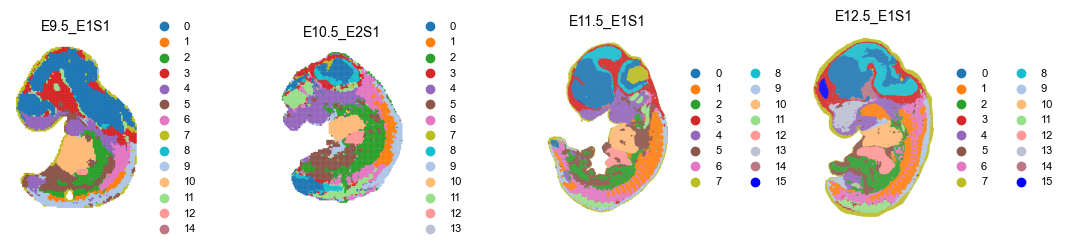

In [9]:
for ss in range(len(section_ids)):
    Batch_list[ss].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[ss]].obs['louvain'].values
    Batch_list[ss].uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat[adata_concat.obs['batch_name'] == 
                                                                            section_ids[ss]].obs['louvain'].unique().astype('int'))]       

import matplotlib.pyplot as plt
spot_size = 1
title_size = 10
fig, ax = plt.subplots(1, len(section_ids), figsize=(len(section_ids)*3, 3), gridspec_kw={'wspace':1, 'hspace': 0.1})    
for ss in range(len(section_ids)-1):
    _sc_0 = sc.pl.spatial(Batch_list[ss], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8, 
                  show=False, frameon=False, ax=ax[ss], spot_size=spot_size)
    _sc_0[0].set_title(section_ids[ss], size=title_size)
_sc_0 = sc.pl.spatial(Batch_list[-1], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8, 
              show=False, frameon=False, ax=ax[-1], spot_size=spot_size)
_sc_0[0].set_title(section_ids[-1], size=title_size)
plt.show()